# Tutorial for the correction of the fixed pattern noise in iSCAT images recorded using a sCMOS camera

The weak residual stripes [[1](https://iopscience.iop.org/article/10.1088/1361-6463/ac2f68)] remaining after Differential Rolling Average ([DRA](https://piscat.readthedocs.io/code_reference.html#piscat.BackgroundCorrection.DifferentialRollingAverage)) are called fixed pattern noise (FPN). A modern CMOS camera typically uses multiple ADCs to improve the imaging speed. The mismatch between the gain and bias of the ADCs [[2](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4014637)] however leaves a FPN on the recorded images. The problem is that the gain and bias parameters temporally fluctuate and therefore FPN is visible even after the subtraction of two consecutive images from each other. The periodicity of such a pattern in our [imaging condition](https://piscat.readthedocs.io/tutorials.html) is about ten pixels which is in the order of the size of a diffraction-limited spot (DLS) of a nano-scatterer. We therefore discuss the effect of FPN on the noise floor behaviour as well as PSF detection sensitivity. We then use a variety of PiSCAT algorithmic approaches based on 
[wavelet transform](https://piscat.readthedocs.io/code_reference.html#piscat.Preproccessing.FrequencyFPNc.update_wFPN) 
[[3](https://www.sciencedirect.com/science/article/abs/pii/S0923596517301522)], [Fourier transform](https://piscat.readthedocs.io/code_reference.html#piscat.Preproccessing.FrequencyFPNc.update_fFPN)[[4](https://www.mdpi.com/1424-8220/18/12/4299)] and [column projection FPN filtering](https://piscat.readthedocs.io/code_reference.html#piscat.Preproccessing.MedianProjectionFPNc) in order to correct for the FPN in the DRA frames.

### Previously ...

In the previous tutorials, we demonstrated how to use PiSCAT's APIs for [setting up the PiSCAT modules and downloading a demo iSCAT video](https://piscat.readthedocs.io/Tutorial1/Tutorial1.html#setting-up-the-piscat-modules-and-downloading-a-demo-iscat-video), [performing basic checks on the acquisition process](https://piscat.readthedocs.io/Tutorial1/Tutorial1.html#examining-the-status-line-removing-it), [suppressing the temporal instability of the laser light](https://piscat.readthedocs.io/Tutorial1/Tutorial1.html#normalization-of-the-power-in-the-frames-of-a-video) and [basic data visualization](https://piscat.readthedocs.io/Tutorial1/Tutorial1.html#display-and-inspect-a-loaded-video). Furthermore, finally we investigated [the noise floor trend](https://piscat.readthedocs.io/Tutorial2/Tutorial2.html#the-effect-of-power-normalization-on-the-detection-limit) along with computing the Differential Rolling Average [DRA](https://piscat.readthedocs.io/Tutorial2/Tutorial2.html#frame-averaging-to-boost-snr-of-imaged-proteins-followed-by-visualization-of-their-signal-via-differential-imaging) of the frames.


In [1]:
# Only to ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Setting up the path to the PiSCAT modules
import os
import sys
current_path = os.path.abspath(os.path.join('..'))
dir_path = os.path.dirname(current_path)
module_path = os.path.join(dir_path)
data_path = os.path.join(dir_path, 'Tutorials', 'Demo data')#The path to the demo data
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Downloading a control video for this tutorial 
from piscat.InputOutput import download_tutorial_data
download_tutorial_data('control_video')    

# Examining the status line in a loaded/downloaded video and removing the status line, PN+DRA
from piscat.InputOutput import reading_videos
from piscat.Visualization import JupyterDisplay
from piscat.InputOutput import read_status_line
from piscat.Preproccessing import normalization
from piscat.BackgroundCorrection import DifferentialRollingAverage
import numpy as np

df_video = reading_videos.DirectoryType(data_path, type_file='raw').return_df()
paths = df_video['Directory'].tolist()
video_names = df_video['File'].tolist()
demo_video_path = os.path.join(paths[0], video_names[0])#Selecting the first entry in the list
video = reading_videos.video_reader(file_name=demo_video_path, type='binary', img_width=128, img_height=128, 
                                    image_type=np.dtype('<u2'), s_frame=0, e_frame=-1)#Loading the video
status_ = read_status_line.StatusLine(video)#Reading the status line
video_remove_status, status_information  = status_.find_status_line()#Examining the status line & removing it
video_pn, _ = normalization.Normalization(video=video_remove_status).power_normalized()
DRA_PN = DifferentialRollingAverage(video=video_pn, batchSize=120)
RVideo_PN_, gainMap1D_DRA = DRA_PN.differential_rolling(FPN_flag=False, FFT_flag=False)


The directory with the name  Demo data  already exists in the following path: F:\PiSCAT_GitHub_development\PiSCAT-Development\Tutorials

The data file named  Control  already exists in the following path: F:\PiSCAT_GitHub_development\PiSCAT-Development\Tutorials\Demo data
---Status line detected in column---

start power_normalized without parallel loop---> Done

--- start DRA ---


  0%|          | 0/4758 [00:00<?, ?it/s]

### Median Projection FPN Correction (mFPNc)
To obtain the simplest and easiest correction approach for lowering the additive element of FPN, subtract the median of each column from the corresponding ones in a differential image formed from the difference of two successive batches B 1 and B 2 of raw frames [[1](https://iopscience.iop.org/article/10.1088/1361-6463/ac2f68)].

To optimize the computational performance, FPNc algorithms and [DifferentialRollingAverage](https://piscat.readthedocs.io/code_reference.html#piscat.BackgroundCorrection.DifferentialRollingAverage) have been integrated inside the same class.

<img src="Fig/mFPN.png" width="750">

In [2]:
DRA_PN_mFPNc = DifferentialRollingAverage(video=video_pn, batchSize=120, mode_FPN='mFPN')
RVideo_PN_mFPNc, gainMap1D_mFPN = DRA_PN_mFPNc.differential_rolling(FPN_flag=True, 
                                                                  select_correction_axis='Both', 
                                                                  FFT_flag=False)


--- start DRA + mFPN_axis: Both---


  0%|          | 0/4758 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done


### mFPN mean-signature

For each correction axis (column or row), the `DifferentialRollingAverage` class returns the corrected video (RVideo_PN_mFPNc) and a set of 1D mean-signatures. These projections assist users in visualizing the impact of FPN. One of these signatures for mFPN correction is plotted in the following cell.

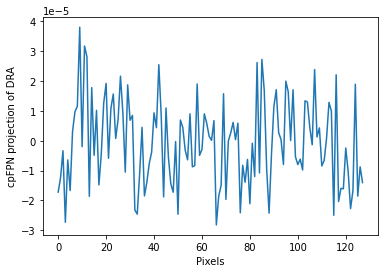

In [3]:
# plotting 1D projection of the first frame for the corrected axis
import matplotlib.pyplot as plt

# For Jupyter notebooks only:
%matplotlib inline
plt.plot(gainMap1D_mFPN[0][500])
plt.xlabel('Pixels')
plt.ylabel('cpFPN projection of DRA')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))


### Column Projection FPN Correction (cpFPNc)

This is a heuristic algorithm in which we first extract the median signature of the column noise by just calculating the median of the image columns as shown in the figure below (subfigure (a)). The image that we work on is a differential image made from two batches B_1 and B_2 of raw frames using the [Differential Rolling Average](https://piscat.readthedocs.io/code_reference.html#piscat.BackgroundCorrection.DifferentialRollingAverage) processing. We note that the median value of pixels in a column will not contain the signal of a particle present in the field of view. This is demonstrated using the blue circles in the figure which encircle the particle's signal in all the steps. The 1D projection plot shows the pixel values with blue dots, the median profile with a red trace and the two upper and lower Median Absolute Deviation (MAD) profiles with black traces. The pixel values corresponding to the blue circle region are above the median and the MAD bands. We then build a binary mask per column, with a threshold value similar to the MAD value. Multiplying the binary mask by the differential image results in a Masked Difference (MD) image. In this manner, we end up partitioning a group of pixels in a column which has values close to their median value, thus omitting the particle's signal. The region marked with the blue circle in the binary mask has zero values and therefore the particle signal is missing in the MD image.

As illustrated in subfigure (b), we compute the column-wise mean of the MD image to obtain the FPN mean-signature with sub-gray level precision. Replicating the 1D mean signature gives us a 2D-FPN map. Finally as shown in subfigure (c), we remove 2D-FPN map from the difference image to get the FPN corrected differential image. 

<img src="Fig/cpFPN.png" width="750">

In [4]:
DRA_PN_cpFPNc = DifferentialRollingAverage(video=video_pn, batchSize=120, mode_FPN='cpFPN')
RVideo_PN_cpFPNc, gainMap1D_cpFPN = DRA_PN_cpFPNc.differential_rolling(FPN_flag=True, 
                                                                      select_correction_axis='Both', 
                                                                      FFT_flag=False)


--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4758 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done


### FFT fixed pattern noise correction (fFPNc):


The new method introduced by Zeng, Qingjie, et al.[[3](https://www.mdpi.com/1424-8220/18/12/4299)] separates image structures from column-wise pattern by windowing in the spectral domain. By using an iterative two-stage filtering technique, the algorithm was able to eliminate stripe nonuniformity from coarse to fine. By combining spectral and spatial filtering, this approach preserves image information. The details of this method are depicted in the diagram below.

<img src="Fig/fFPN.png" width="900">

In [5]:
DRA_PN_wFPN = DifferentialRollingAverage(video=video_pn, batchSize=120, mode_FPN='fFPN')
RVideo_PN_fFPN, gainMap1D_fFPN = DRA_PN_wFPN.differential_rolling(FPN_flag=True, select_correction_axis='Both', 
                                                                 FFT_flag=False, inter_flag_parallel_active=False,
                                                                    max_iterations=30)


--- start DRA + fFPN_axis: Both---


  0%|          | 0/4758 [00:00<?, ?it/s]


---start fFPNc without Parallel---


  0%|          | 0/4759 [00:00<?, ?it/s]


---start fFPNc without Parallel---


  0%|          | 0/4759 [00:00<?, ?it/s]

### Display and compare different FPNc:

The [JupyterFPNcDisplay](https://piscat.readthedocs.io/code_reference.html#piscat.Visualization.JupyterFPNcDisplay) class in ``display_jupyter``, is developed for visualization of different FPNc videos. For each FPN correction method, images are projected along the columns/rows and plotted with blue dots. For each column, we obtain the mean of those pixel values which is plotted in red.

In [1]:
from piscat.Visualization import JupyterFPNcDisplay
list_videos = [RVideo_PN_, RVideo_PN_mFPNc, RVideo_PN_cpFPNc, RVideo_PN_fFPN]
list_titles = ['DRA_PN', 'mFPNc', 'cpFPNc', 'fFPNc']
%matplotlib inline
JupyterFPNcDisplay(list_videos=list_videos, list_titles=list_titles, correction_axis=1, 
                     numRows=1, numColumns=4, imgSizex=15, imgSizey=15, median_filter_flag=False, color='gray')

ModuleNotFoundError: No module named 'piscat'

### FPNc spatial benchmarking

The lateral extent of the microscope PSF is a key spatial feature for detecting nanoparticles, as we discuss it thoroughly in [the protein localization section](https://piscat.readthedocs.io/Tutorial4/Tutorial4.html). The spatial periodicity of the FPN is sometimes in the order of the PSF size. Therefore, in the presence of FPN some PSF-like features are added to the detected signals. Therefore we can also compare the quality of FPN correction simply by considering the number of false particle detections in the blank videos with FPNc being done with different methods but with the same hyperparameters of localization algorithm. The following interactive displays depict mFPNc and cpFPNc that have 8 and 7 false detections while fFPN video has 2 false detection for the same threshold of 6e-5 on the frame number 1000. 

In [12]:
from piscat.Localization import PSFsExtraction
%matplotlib inline
PSF_1 = PSFsExtraction(video=RVideo_PN_mFPNc)
PSFs = PSF_1.psf_detection_preview(function='dog', 
                            min_sigma=1.6, max_sigma=1.7, sigma_ratio=1.1, threshold=6e-5,
                            overlap=0, mode='BOTH', frame_number=[1000], IntSlider_width='400px', 
                                   title='Localization threshold on mFPNc')

PSF_l = PSFsExtraction(video=RVideo_PN_cpFPNc)
PSFs = PSF_l.psf_detection_preview(function='dog', 
                            min_sigma=1.6, max_sigma=1.7, sigma_ratio=1.1, threshold=6e-5,
                            overlap=0, mode='BOTH', frame_number=[1000], IntSlider_width='400px', 
                                   title='Localization threshold on cpFPNc')

PSF_l = PSFsExtraction(video=RVideo_PN_fFPN)
PSFs = PSF_l.psf_detection_preview(function='dog',
                           min_sigma=1.6, max_sigma=1.7, sigma_ratio=1.1, threshold=6e-5,
                           overlap=0, mode='BOTH', frame_number=[1000], IntSlider_width='400px',
                                  title='Localization threshold on fFPNc')


interactive(children=(FloatSlider(value=6e-05, continuous_update=False, description='Threshold', layout=Layout…

interactive(children=(FloatSlider(value=6e-05, continuous_update=False, description='Threshold', layout=Layout…

interactive(children=(FloatSlider(value=6e-05, continuous_update=False, description='Threshold', layout=Layout…

### FPNc temporal benchmarking


The noise floor curve illustrates the comparison between mFPNc, cpFPNc and fFPNc for the difference in their performance regarding background temporal fluctuations. FPN comprises both additive and multiplicative terms; mFPN and cpFPN correct the additive component, whereas fFPN corrects FPN in the frequency domain by converting the multiplicative terms to additive terms. The multiplicative part of the FPN is thus adjusted by edge preserving filtering, resulting in an increase in the feasible minimum temporal noise floor. To summarize, fFPN is most appropriate when FPN is caused by a mismatch in ADC gain (multiplicative), but with our camera, FPN is caused by a disparity in ADC offset (additive). In this instance, mFPN or cpFPN are more effective.

In [8]:
# Noise floor analysis

from piscat.BackgroundCorrection import NoiseFloor
l_range = list(range(30, 200, 30))
noise_floor_DRA = NoiseFloor(video_pn, list_range=l_range, FPN_flag=False)

noise_floor_mFPN = NoiseFloor(video_pn, list_range=l_range, select_correction_axis='Both',
                           FPN_flag=True, mode_FPN='mFPN')

noise_floor_cpFPN = NoiseFloor(video_pn, list_range=l_range, select_correction_axis='Both',
                           FPN_flag=True, mode_FPN='cpFPN')

noise_floor_fFPN = NoiseFloor(video_pn, list_range=l_range, select_correction_axis='Both',
                           FPN_flag=True, mode_FPN='fFPN',  max_iterations=10)


The noise floor is running without parallel loop!

--- start DRA ---


  0%|          | 0/4938 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/4878 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/4818 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/4758 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/4698 [00:00<?, ?it/s]


--- start DRA ---


  0%|          | 0/4638 [00:00<?, ?it/s]


The noise floor is running without parallel loop!

--- start DRA + mFPN_axis: Both---


  0%|          | 0/4938 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4939 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4939 [00:00<?, ?it/s]

Done

--- start DRA + mFPN_axis: Both---


  0%|          | 0/4878 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4879 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4879 [00:00<?, ?it/s]

Done

--- start DRA + mFPN_axis: Both---


  0%|          | 0/4818 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4819 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4819 [00:00<?, ?it/s]

Done

--- start DRA + mFPN_axis: Both---


  0%|          | 0/4758 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done

--- start DRA + mFPN_axis: Both---


  0%|          | 0/4698 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4699 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4699 [00:00<?, ?it/s]

Done

--- start DRA + mFPN_axis: Both---


  0%|          | 0/4638 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/4639 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/4639 [00:00<?, ?it/s]

Done

The noise floor is running without parallel loop!

--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4938 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4939 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4939 [00:00<?, ?it/s]

Done

--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4878 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4879 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4879 [00:00<?, ?it/s]

Done

--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4818 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4819 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4819 [00:00<?, ?it/s]

Done

--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4758 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4759 [00:00<?, ?it/s]

Done

--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4698 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4699 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4699 [00:00<?, ?it/s]

Done

--- start DRA + cpFPN_axis: Both---


  0%|          | 0/4638 [00:00<?, ?it/s]


cpFPN correction without parallel loop ---> 

  0%|          | 0/4639 [00:00<?, ?it/s]

Done

cpFPN correction without parallel loop ---> 

  0%|          | 0/4639 [00:00<?, ?it/s]

Done

The noise floor is running without parallel loop!

--- start DRA + fFPN_axis: Both---


  0%|          | 0/4938 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4939 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4939 [00:00<?, ?it/s]


--- start DRA + fFPN_axis: Both---


  0%|          | 0/4878 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4879 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4879 [00:00<?, ?it/s]


--- start DRA + fFPN_axis: Both---


  0%|          | 0/4818 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4819 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4819 [00:00<?, ?it/s]


--- start DRA + fFPN_axis: Both---


  0%|          | 0/4758 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4759 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4759 [00:00<?, ?it/s]


--- start DRA + fFPN_axis: Both---


  0%|          | 0/4698 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4699 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4699 [00:00<?, ?it/s]


--- start DRA + fFPN_axis: Both---


  0%|          | 0/4638 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4639 [00:00<?, ?it/s]


---start fFPNc with Parallel---


  0%|          | 0/4639 [00:00<?, ?it/s]

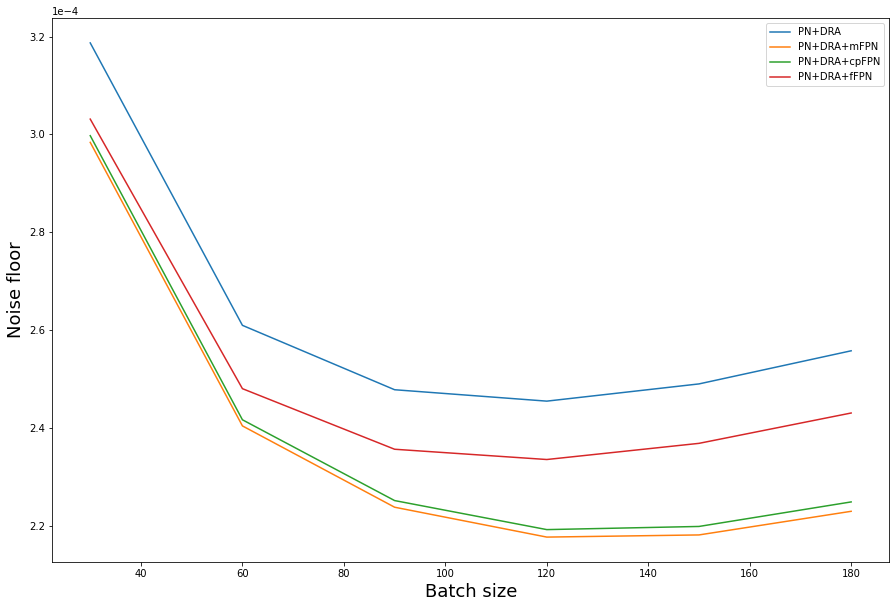

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15, 10))
plt.plot(l_range, noise_floor_DRA.mean, label='PN+DRA')
plt.plot(l_range, noise_floor_mFPN.mean, label='PN+DRA+mFPN')
plt.plot(l_range, noise_floor_cpFPN.mean, label='PN+DRA+cpFPN')
plt.plot(l_range, noise_floor_fFPN.mean, label='PN+DRA+fFPN')
plt.xlabel("Batch size", fontsize=18)
plt.ylabel("Noise floor", fontsize=18)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend()

### Bibliography
1. [Mirzaalian Dastjerdi, Houman, et al. "Optimized analysis for sensitive detection and analysis of single proteins via interferometric scattering microscopy." Journal of Physics D: Applied Physics (2021).](http://iopscience.iop.org/article/10.1088/1361-6463/ac2f68)

2. [Snoeij, Martijn F., et al. "A CMOS imager with column-level ADC using dynamic column fixed-pattern noise reduction." IEEE Journal of Solid-State Circuits 41.12 (2006): 3007-3015.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4014637)

3. [Cao, Yanlong, et al. "A multi-scale non-uniformity correction method based on wavelet decomposition and guided filtering for     uncooled long wave infrared camera." Signal Processing: Image Communication 60 (2018): 13-21.](https://www.sciencedirect.com/science/article/abs/pii/S0923596517301522)

4. [Zeng, Qingjie, et al. "Single infrared image-based stripe nonuniformity correction via a two-stage filtering method." Sensors 18.12 (2018): 4299.](https://www.mdpi.com/1424-8220/18/12/4299)